<h2 style="text-align:center;">A self-training semi-supervised Deep learning approach for improving the accuracy and efficiency of fake news detection<br/></h2>

## 1. Import Libraries and Dataset

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Dataset'
fake_news_data = pd.read_csv('/content/drive/MyDrive/Dataset/Fake.csv', sep=',', encoding='latin')
true_news_data = pd.read_csv('/content/drive/MyDrive/Dataset/True.csv', sep=',', encoding='latin')


In [5]:
# Add a label column to indicate whether the news is fake (1) or true (0)
fake_news_data['label'] = '0'
true_news_data['label'] = '1'

In [6]:
# Combine the datasets into a single DataFrame
data = pd.concat([fake_news_data, true_news_data], ignore_index=True, sort=False)


In [7]:
# Shuffle the combined dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

## 2. Overview of Data

In [8]:
# Show the first 20 rows of the data
data.head(20)

title  \
0        Ben Stein Calls Out 9th Circuit Court: Committed a âCoup dâÃ©tatâ Against the Constitution   
1                                                 Trump drops Steve Bannon from National Security Council   
2                                        Puerto Rico expects U.S. to lift Jones Act shipping restrictions   
3                OOPS: Trump Just Accidentally Confirmed He Leaked Israeli Intelligence To Russia (VIDEO)   
4                                                 Donald Trump heads for Scotland to reopen a golf resort   
5                  Paul Ryan Responds To Demâs Sit-In On Gun Control In The Most DISGUSTING Way (VIDEO)   
6                     AWESOME! DIAMOND AND SILK Rip Into The Press: âWe donât believe you!â [Video]   
7   STAND UP AND CHEER! UKIP Party Leader SLAMS Germany, France And EU Invasion Of Phony Refugees [VIDEO]   
8                                    North Korea shows no sign it is serious about talking: U.S. official   
9                                                    Trump signals willingness to raise U.S. minimum wage   
10                                       New Jersey's Christie mulls run to lead Republican Party: report   
11                                                        WHEREâS HILLARY? CLINTON SPOTTED Dining Alone   
12                                         France, Germany want Iran to reverse ballistic missile program   
13                    Aide to EU Commission head tweets picture of white smoke at Brexit meeting with May   
14                       Trump Issues Warning To â200,000 man armyâ That âCould be ISIS â [Video]   
15                                    U.S. gives Laos extra $90 million to help clear unexploded ordnance   
16                        JUDGE DECLARES BABY NAME âIllegalâ To Prevent Her From âEmotional Harmâ   
17   Paul Ryan Takes A Monumentally HUMILIATING Photo With A Constituent Who EXPERTLY Trolled Him (IMAGE)   
18                      Republicans Dine With Trump, Then Try To Railroad Comey Into Clearing Him (VIDEO)   
19                                         U.S. House panel offers alternative to retirement adviser rule   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [9]:
# Get the number of rows and columns
n_rows = data.shape[0]
n_cols = data.shape[1]

In [10]:
print(f'The data has {n_rows} rows and {n_cols} columns')

The data has 44898 rows and 5 columns


In [11]:
data['text'].unique()

array(['21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements on Judge Jeanine Pirro s show recently. While discussing the halt that was imposed on President Trump s Executive Order on travel. Stein referred to the judgement by the 9th Circuit Court in Washington state as a  Coup d tat against the executive branch and against the constitution.  Stein went on to call the Judges in Seattle  political puppets  and the judiciary  political pawns. Watch the interview below for the complete statements and note the stark contrast to the rhetoric of the leftist media and pundits who neglect to note that no court has ever blocked any Presidential orders in immigration in the past or discuss the legal efficacy of the halt or the actual text of the Executive Order.READ MORE TRUMP NEWS AT: 21st Century Wire Trump FilesSUPPORT OUR WORK BY SUBSCR

In [12]:
data['text'].value_counts()

In [13]:
# Check if there are duplicated data
data.duplicated().sum()

209

In [14]:
# Check for null values in the data
data[data.text.isna()]

,title,text,subject,date,label


### Drop Duplicated rows

In [15]:
data.drop_duplicates(inplace=True)

In [16]:
data.dropna(inplace=True)

## 3. Exploratory Data Analysis

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In [18]:
target_count = data['label'].value_counts(normalize=True)
target_count

0    0.525364
1    0.474636
Name: label, dtype: float64

In [19]:
fig = px.histogram(data, x='label', title='Fake News vs True News')
fig.update_layout(title_x=1)

fig.show()

In [20]:
fig = px.pie(
    target_count, values=target_count.values, names=['Fake News', 'True News'],
    title='Proportion of Fake and True News',
)

fig.update_layout(legend_title_text='label', title_x=0.3, title_y=0.95)

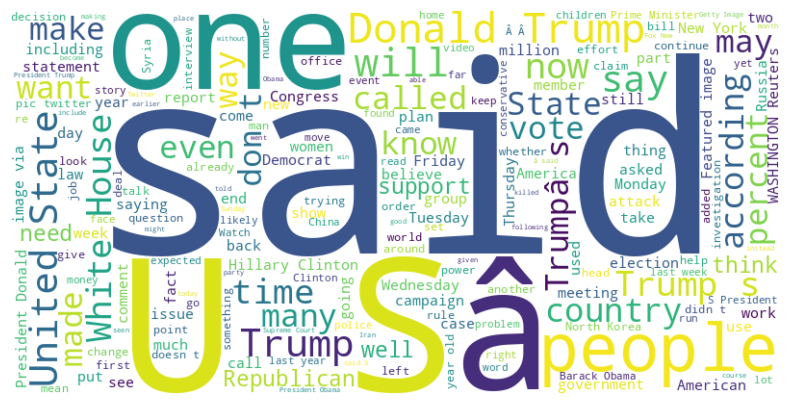

In [21]:
all_text = ' '.join(data['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4. Data Preparation and Preprocessing

In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re  # for regular expressions


# Download NLTK resources (stopwords, punkt, and wordnet)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Pre-processiong

In [23]:
# Set up stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [24]:
 #Tokenization, Lowercasing, Special Characters Removal, and Lemmatization function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

    return ' '.join(tokens)

In [25]:
data['text'] = data['text'].apply(preprocess_text)

In [26]:
data['text']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Define the proportion of labeled data to convert to unlabeled

In [27]:
# Define the proportion of labeled data to convert to unlabeled
unlabeled_proportion = 0.6  # 60%
# Split the labeled data into labeled and unlabeled parts
labeled_data, unlabeled_data = train_test_split(data, test_size=unlabeled_proportion, random_state=42)
labeled_data = labeled_data.reset_index(drop=True)
unlabeled_data = unlabeled_data.reset_index(drop=True)
unlabeled_data.drop(columns=['label'])


title  \
0                                                          Turks safe in Germany, Merkel says, dismissing Ankara's warning   
1       âRacist, Fascist, White Supremacistâ: Former NFL Star Chris Kluwe Scorches Trump Over His Attacks On Atheletes   
2                           THIS ONE PICTURE Tells You Just How Delusional Hillary Has Become About The Trouble Sheâs In   
3                                                     Factbox: Five facts about Mike Pompeo, expected to replace Tillerson   
4                               Loan Officer Fired From Her Job After Posting A HORRIBLY Racist Tweet About Michelle Obama   
...                                                                                                                    ...   
26809                                                             Illinois budget uncertainty extends into new fiscal year   
26810                                               White House defends portrayal of 'armada' push toward Korean peninsula   
26811                                                                            Trump's pick for Army secretary drops out   
26812                                                                   Fake meat, free markets ease North Koreans' hunger   
26813    OOPS! Black Security Guard Wonât Allow White Dude Wearing Black Lives Matter T-Shirt Into Hillary Event [VIDEO]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [28]:
labeled_texts = labeled_data['text']
unlabeled_texts = unlabeled_data['text']

# Convert labels to one-hot encoding

In [29]:
labels = labeled_data['label']
one_hot_encoder = OneHotEncoder(sparse=True)
one_hot_labels = one_hot_encoder.fit_transform(labels.values.reshape(-1, 1))

# Initial Training

In [30]:
one_hot_labels.shape

(17875, 2)

In [31]:
# Define your deep learning model architecture
# def create_model(input_dim, num_classes):
#     model = Sequential([
#         Dense(64, activation='relu', input_shape=(input_dim,)),
#         Dense(32, activation='relu'),
#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score()])
#     return model

In [32]:
def create_model(input_dim, num_classes):
    # Input layer
    input_layer = Input(shape=(input_dim,))

    # Stacked Sparse Autoencoder layers
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    # Classifier layers
    classifier_output = Dense(num_classes, activation='softmax')(encoded)

    # Combine autoencoder and classifier
    model = Model(inputs=input_layer, outputs=[classifier_output, decoded])

    # Compile model
    model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'], metrics=['accuracy'])

    return model

In [33]:
# Split labeled data for initial training
input_dim = labeled_data.shape[1]  # Replace with the actual input dimension
num_classes =len(np.unique(labels))
# Split into test and temporary set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    labeled_texts, one_hot_labels, test_size=0.2, random_state=42)
# Split the temporary set into training and validation
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42)





In [34]:
type(X_labeled_train)

pandas.core.series.Series

In [35]:
num_classes

2

In [36]:
# TF-IDF Vectorization for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5)  # Adjust max_features as needed
X_labeled_train_tfidf = tfidf_vectorizer.fit_transform(X_labeled_train)
X_labeled_val_tfidf = tfidf_vectorizer.transform(X_labeled_val)
# Convert to dense tensors
X_labeled_train_dense = tf.convert_to_tensor(X_labeled_train_tfidf.toarray(), dtype=tf.float32)
X_labeled_val_dense = tf.convert_to_tensor(X_labeled_val_tfidf.toarray(), dtype=tf.float32)

# Convert labels to dense tensors
y_labeled_train_dense = tf.convert_to_tensor(y_labeled_train.toarray(), dtype=tf.float32)
y_labeled_val_dense = tf.convert_to_tensor(y_labeled_val.toarray(), dtype=tf.float32)


In [37]:
X_labeled_train_dense

<tf.Tensor: shape=(10725, 5), dtype=float32, numpy=
array([[0.09534541, 0.5272643 , 0.79921335, 0.19451617, 0.19058637],
       [0.        , 0.6123098 , 0.        , 0.7906179 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.6020299 , 0.79847354, 0.        , 0.        ],
       [0.        , 0.1852321 , 0.9826948 , 0.        , 0.        ],
       [0.10619577, 0.33558127, 0.22254105, 0.32497832, 0.8491008 ]],
      dtype=float32)>

In [38]:
# Create and train the initial model
#initial_model = create_model(X_labeled_train_tfidf.shape[1], num_classes)
initial_model = create_model(X_labeled_train_dense.shape[1], num_classes)
#initial_model.fit(X_labeled_train_dense, y_labeled_train_dense, epochs=20, validation_data=(X_labeled_val_dense, y_labeled_val_dense))
initial_model.fit(X_labeled_train_dense, [y_labeled_train_dense, X_labeled_train_dense], epochs=20, validation_data=(X_labeled_val_dense, [y_labeled_val_dense, X_labeled_val_dense]))


Epoch 1/20
336/336 [==============================] - 3s 4ms/step - loss: 0.5519 - dense_6_loss: 0.5174 - dense_5_loss: 0.0346 - dense_6_accuracy: 0.7612 - dense_5_accuracy: 0.7528 - val_loss: 0.4940 - val_dense_6_loss: 0.4899 - val_dense_5_loss: 0.0042 - val_dense_6_accuracy: 0.7787 - val_dense_5_accuracy: 0.8571
Epoch 2/20
336/336 [==============================] - 1s 3ms/step - loss: 0.4946 - dense_6_loss: 0.4918 - dense_5_loss: 0.0028 - dense_6_accuracy: 0.7731 - dense_5_accuracy: 0.8876 - val_loss: 0.4973 - val_dense_6_loss: 0.4949 - val_dense_5_loss: 0.0023 - val_dense_6_accuracy: 0.7754 - val_dense_5_accuracy: 0.8694
Epoch 3/20
336/336 [==============================] - 2s 5ms/step - loss: 0.4878 - dense_6_loss: 0.4861 - dense_5_loss: 0.0016 - dense_6_accuracy: 0.7742 - dense_5_accuracy: 0.8915 - val_loss: 0.4884 - val_dense_6_loss: 0.4871 - val_dense_5_loss: 0.0013 - val_dense_6_accuracy: 0.7804 - val_dense_5_accuracy: 0.8901
Epoch 4/20
336/336 [==============================] 

In [39]:
enlarged_dataset = pd.DataFrame(columns=['text', 'label'])
unlabeled_texts = np.array(unlabeled_texts)


In [40]:
# Step 4: Distance-Based Sampling Criterion (DBSC)
def db_sc(x, y):
    return np.linalg.norm(x - y)**2  # Euclidean distance as the confidence measure

In [41]:
# Dynamic Sampling Strategy (Sample based on prediction confidence)
def Selected_Samples(unlabled_data: np.ndarray):
    unlabeled_texts_tfidf = tfidf_vectorizer.transform(unlabled_data)
    # Convert text data to a dense matrix
    unlabeled_texts_tfidf_dense = tf.convert_to_tensor(unlabeled_texts_tfidf.toarray(), dtype=tf.float32)
    #unlabeled_predictions = initial_model.predict(unlabeled_texts_tfidf_dense)
    unlabeled_predictions, decoded_texts = initial_model.predict(unlabeled_texts_tfidf_dense)
    confidence_threshold = 0.7  # Define your confidence threshold
    selected_indices = np.where(np.max(unlabeled_predictions, axis=1) >= confidence_threshold)[0]
    selected_samples = unlabled_data[selected_indices]

    # Assign pseudo-labels based on the predictions
    pseudo_labels = np.argmax(unlabeled_predictions[selected_indices], axis=1)
    # Compute distances between pseudo-labeled samples and labeled samples
    selected_samples = np.array(selected_samples)
    selected_samples_dense = tfidf_vectorizer.transform(selected_samples).toarray()
    distances = cdist(selected_samples_dense, X_labeled_train_dense, metric=db_sc)
    min_distances = np.min(distances, axis=1)
    # Sort pseudo-labeled samples based on distance (ascending order)
    sorted_indices = np.argsort(min_distances)
    sorted_samples = selected_samples[sorted_indices]
   # Convert selected samples to numpy array before concatenation
    sorted_samples = np.array(sorted_samples)

    sorted_pseudo_labels = pseudo_labels[sorted_indices]
    return (sorted_samples, sorted_pseudo_labels, decoded_texts[selected_indices])



In [42]:
# Step 5: Gradual Sample Inclusion (Include a growing number of pseudo-labeled samples)
num_initial_samples = 500  # Define the initial number of pseudo-labeled samples
num_samples = 0
gradual_inclusion_rate = 1000  # Define the rate of gradual inclusion

In [43]:
combined_data = X_labeled_train
combined_labels = labels

In [44]:
 print(type(combined_data))

<class 'pandas.core.series.Series'>


In [45]:
num_classes

2

In [46]:
print(type(unlabeled_texts))



<class 'numpy.ndarray'>


In [47]:

for i in range(num_initial_samples, len(unlabeled_texts), gradual_inclusion_rate):
    selected_samples, sorted_pseudo_labels, decoded_texts =Selected_Samples(unlabeled_texts[num_samples:i+gradual_inclusion_rate])

    # Assign pseudo-labels based on the predictions

    combined_data = pd.concat([combined_data, pd.DataFrame(selected_samples)], ignore_index=True)

    combined_labels = np.concatenate((combined_labels, sorted_pseudo_labels))

    tfidf_vector = tfidf_vectorizer.transform(selected_samples).toarray()
    tfidf_vector_dense = tf.convert_to_tensor(tfidf_vector, dtype=tf.float32)

    pseudo_label_one_hot= one_hot_encoder.fit_transform(sorted_pseudo_labels.reshape(-1, 1))

    sorted_pseudo_labels_dense = tf.convert_to_tensor(pseudo_label_one_hot.toarray(), dtype=tf.float32)

    # Update the model with the new sample
    #initial_model.fit(tfidf_vector_dense, sorted_pseudo_labels_dense, epochs=20, verbose=0)
    initial_model.fit(tfidf_vector_dense, [sorted_pseudo_labels_dense, tfidf_vector_dense], epochs=20, verbose=0)

    # Monitor the model's performance on the validation set
    # val_evaluation_metrics = initial_model.evaluate(X_labeled_val_dense, [y_labeled_val_dense, X_labeled_val_dense], verbose=0)
    # val_accuracy = val_evaluation_metrics[0]
    # print(f'Validation Accuracy after {i} samples: {val_accuracy:.4f}')
    val_evaluation_metrics = initial_model.evaluate(X_labeled_val_dense, [y_labeled_val_dense, X_labeled_val_dense], verbose=0)
    val_accuracy_classifier = val_evaluation_metrics[3]  # Index 3 corresponds to classifier accuracy
    val_accuracy_autoencoder = val_evaluation_metrics[4]  # Index 4 corresponds to autoencoder loss (assuming it represents reconstruction accuracy)

    print(f'Validation Classifier Accuracy after {i} samples: {val_accuracy_classifier:.4f}')
    print(f'Validation Autoencoder Accuracy after {i} samples: {val_accuracy_autoencoder:.4f}')





47/47 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 500 samples: 0.7801
Validation Autoencoder Accuracy after 500 samples: 0.8794
79/79 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 1500 samples: 0.7804
Validation Autoencoder Accuracy after 1500 samples: 0.8814
110/110 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 2500 samples: 0.7796
Validation Autoencoder Accuracy after 2500 samples: 0.8811
141/141 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 3500 samples: 0.7813
Validation Autoencoder Accuracy after 3500 samples: 0.8738
172/172 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 4500 samples: 0.7801
Validation Autoencoder Accuracy after 4500 samples: 0.8864
204/204 [==============================] - 0s 2ms/step
Validation Classifier Accuracy after 5500 samples: 0.7813
Validation Autoencoder Accuracy a

In [51]:
# Evaluate your model on a separate test set or validation set
# Use metrics like accuracy, precision, recall, etc.
#X_test_tfidf = tfidf_vectorizer.transform(unlabeled_texts_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf_dense = tf.convert_to_tensor(X_test_tfidf.toarray(), dtype=tf.float32)


y_test_dense = tf.convert_to_tensor(y_test.toarray(), dtype=tf.float32)
#
# Predictions on the test set
y_pred_classifier, decoded_texts = initial_model.predict(X_test_tfidf_dense)

# Convert predicted probabilities to binary predictions for the classifier
y_pred_binary = np.argmax(y_pred_classifier, axis=1)

# Convert true labels to binary format
y_true_binary = np.argmax(y_test_dense, axis=1)

# Calculate evaluation metrics for the classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_classifier = accuracy_score(y_true_binary, y_pred_binary)
precision_classifier = precision_score(y_true_binary, y_pred_binary)
recall_classifier = recall_score(y_true_binary, y_pred_binary)
f1_classifier = f1_score(y_true_binary, y_pred_binary)

print("Classifier Evaluation Metrics:")
print(f" - Accuracy: {accuracy_classifier:.4f}")
print(f" - Precision: {precision_classifier:.4f}")
print(f" - Recall: {recall_classifier:.4f}")
print(f" - F1 Score: {f1_classifier:.4f}")

# Calculate evaluation metrics for the autoencoder (assuming reconstruction accuracy)
# Reconstruction accuracy is not a standard metric, but you can use it to evaluate the quality of reconstructed texts
# Here, we assume that lower reconstruction loss indicates higher accuracy
#reconstruction_loss = initial_model.evaluate(X_test_tfidf_dense, decoded_texts, verbose=0)

print("Autoencoder Reconstruction Loss:")
#print(f" - Loss: {reconstruction_loss:.4f}")


112/112 [==============================] - 0s 3ms/step
Classifier Evaluation Metrics:
 - Accuracy: 0.7706
 - Precision: 0.7131
 - Recall: 0.8594
 - F1 Score: 0.7795
Autoencoder Reconstruction Loss:
